In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
# Camera calibration
def calibrate_camera(images, draw_corners=None):
    '''
    Calibarate the camera with a list of images
    
    Params:
    images: a list of images taken by the camera, used to calibrate the camera
    draw_corners: if true, draw the found corners on the image
    
    Return: camera matrix, distortion coefficient
    '''
    # Two lists to store object points and image points
    objpoints = []
    imgpoints = []
    
    # Prepare object points
    objp = np.zeros([6*9, 3], np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    # Step through each image
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
        
        # If found corners, add the image points and correponding object points
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # If needed, draw the corners on the image
            if draw_corners == True:
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img) 
    
    # Calibrate camera with object points and image points
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return mtx, dist   

In [3]:
# Calibrate the camera with calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(images)

In [4]:
# Threshold the image with gradients and color 
def threshold_image(img, grad_mag_thresh=(30, 100), grad_dir_thresh=(np.pi/4, np.pi/2), 
                color_threshold=(0,255), color_channel='L', use_direction='both'):
    '''
    Threshold with both gradients filter and color filters
    
    Params:
    img: an undistorted image
    grad_mag_thresh: gradient magnitude threshold, could be either direction or both
    grad_dir_thresh: gradient direction threshold
    color_threshold: color threshold 
    color_channel: 'L' or 'S'
    use_direction: choose the direction for gradient threshold
    
    Return: a binary file with visible lane lines
    '''
    
    # First, get the gradient filter
    # Convert color image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradient with Sobel
    sobelx64f = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely64f = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate gradient magnitude and convert to uint8
    if use_direction == 'both':
        grad_mag64f = np.sqrt(sobelx64f**2 + sobely64f**2)
        grad_mag = np.uint8(grad_mag64f*255/np.max(grad_mag64f))
    elif use_direction == 'X':
        sobelx = np.abs(sobelx64f)
        grad_mag = np.uint8(sobelx*255/np.max(sobelx))
    elif use_direction == 'Y':
        sobely = np.abs(sobely64f)
        grad_mag = np.uint8(sobely*255/np.max(sobely))
    
    # Calculate gradient direction
    grad_dir_value = np.abs(sobely64f/sobelx64f)
    grad_dir = np.arctan(grad_dir_value)
    
    # Get gradient filter mask
    mask_grad = (grad_mag>grad_mag_thresh[0])&(grad_mag<grad_mag_thresh[1])\
           &(grad_dir>grad_dir_thresh[0])&(grad_dir<grad_dir_thresh[1])
   
    
    # Second, get the color filter 
    #Convert the image to HLS and split channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L, S = hls[:,:,1], hls[:,:,2]
    
    # Get color filter mask
    if color_channel == 'L':
        channel = np.copy(L)
    elif color_channel == 'S':
        channel = np.copy(S)    
    mask_color = (channel>color_threshold[0])&(channel<=color_threshold[1])
    
    # Apply both masks
    binary = np.zeros_like(gray)
    binary[mask_grad&mask_color]=1
    
    return binary

In [15]:
# Perspective transform
def transform_perspective(img):
    h, w = img.shape[0], img.shape[1]
    
     # Four source points
    src = np.float32(
          [[215, 705],
          [576, 460],
          [705, 460],
          [1098, 705]])

    # Four destination points
    dst = np.float32(
         [[350, 720],
          [350, 0],
          [950, 0],
          [950, 720]])

    # Compute transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped

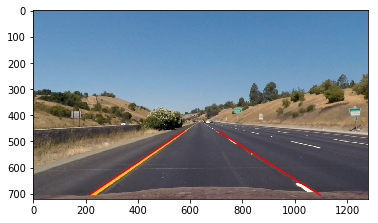

In [14]:
%matplotlib qt

plt.imshow(undist)

# Four source points
src = np.float32(
     [[215, 705],
      [576, 460],
      [705, 460],
      [1098, 705]])

# Four destination points
dst = np.float32(
     [[350, 720],
      [350, 0],
      [950, 0],
      [950, 720]])
plt.plot((src[0,0], src[1,0]), (src[0,1], src[1,1]), 'r-')
plt.plot((src[2,0], src[3,0]), (src[2,1], src[3,1]), 'r-')

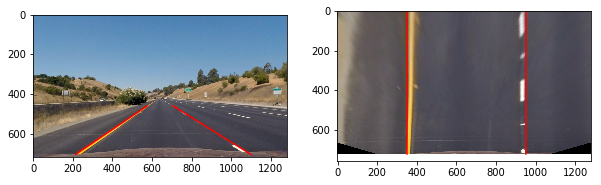

In [16]:
%matplotlib inline

warped = transform_perspective(undist)

fig = plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(undist)
plt.plot((src[0,0], src[1,0]), (src[0,1], src[1,1]), 'r-')
plt.plot((src[2,0], src[3,0]), (src[2,1], src[3,1]), 'r-')

plt.subplot(122), plt.imshow(warped)
plt.plot((dst[0,0], dst[1,0]), (dst[0,1], dst[1,1]), 'r-')
plt.plot((dst[2,0], dst[3,0]), (dst[2,1], dst[3,1]), 'r-')

In [133]:
# Find the lines
def find_line(img):
    '''
    Find the lane lines using sliding window search
    
    Params:
    img: warped, binary image with bird's view
    '''
    window_height = 

In [134]:
# Calculate curvature and position
def calculate_curvature(img):
    return None

In [23]:
# Build the pipeline
def pipeline(img, mtx, dist, grad_mag_thresh=(20, 200), grad_dir_thresh=(0, np.pi/2), 
                color_threshold=(90,255), color_channel='S', use_direction='both'):
    '''
    The pipeline takes an image as input, through thresholding, perspective transform, and lane line detecting. 
    
    Params:
    
    Return: visible lane line area, instant position and lane line curvature
    '''
    
    # Step 1, undistort the image
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Step 2, threshold the image to get a binary output
    binary = threshold_image(undistort, grad_mag_thresh, grad_dir_thresh, color_threshold, color_channel, use_direction)
    
    # Step 3, perspective transform
    warped = transform_perspective(binary)
    
    # step 4, find the lane line
    
    
    return warped, binary, undistort
    

/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


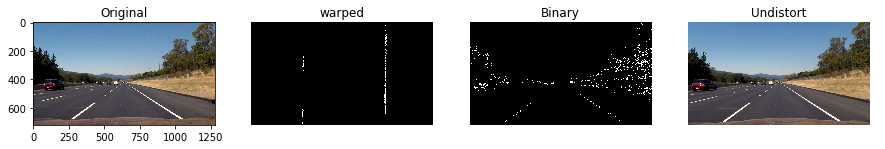

In [39]:
# Test the pipeline
fl = './test_images/straight_lines2.jpg'
img = mpimg.imread(fl)

output, binary, undistort = pipeline(img, mtx, dist, grad_mag_thresh=(20,100), use_direction='both', 
                                     color_threshold=(90,255), color_channel='S')

f, Axes = plt.subplots(1, 4, figsize=(15,5))
plt.tight_layout

Axes[0].imshow(img)
Axes[0].set_title('Original')

Axes[1].imshow(output, cmap='gray'), Axes[1].axis('off')
Axes[1].set_title('warped')

Axes[2].imshow(binary, cmap='gray'), Axes[2].axis('off')
Axes[2].set_title('Binary')

Axes[3].imshow(undistort), Axes[3].axis('off')
Axes[3].set_title('Undistort')

In [7]:
# Test the undistortion function
fl = './test_images/straight_lines1.jpg'
img = mpimg.imread(fl)
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig = plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title('Original image')
plt.subplot(122), plt.imshow(undist)
plt.title('Undistorted image')


/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


(<matplotlib.axes._subplots.AxesSubplot at 0x16c18c588>,
 <matplotlib.text.Text at 0x130761128>)

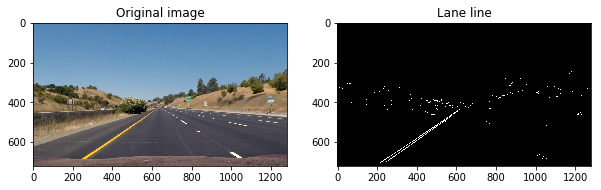

In [310]:
# Test detect_laneline function
grad_mag_thresh=(30, 200)
grad_dir_thresh=(np.pi/4, np.pi/2)
color_threshold=(30,255)
color_channel='S'
use_direction = 'X'
binary = detect_laneline(undist, grad_mag_thresh, grad_dir_thresh, color_threshold, color_channel, use_direction)

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title('Original image')
plt.subplot(122), plt.imshow(binary, cmap='gray'), plt.title('Lane line')

In [350]:
np.mgrid[:9, :6].T.reshape(-1,2)

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [5, 2],
       [6, 2],
       [7, 2],
       [8, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3],
       [4, 3],
       [5, 3],
       [6, 3],
       [7, 3],
       [8, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [3, 4],
       [4, 4],
       [5, 4],
       [6, 4],
       [7, 4],
       [8, 4],
       [0, 5],
       [1, 5],
       [2, 5],
       [3, 5],
       [4, 5],
       [5, 5],
       [6, 5],
       [7, 5],
       [8, 5]])

In [347]:
mesh = np.meshgrid(np.arange(5), np.arange(3))
np.array(mesh).T.reshape(-1,2)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2],
       [3, 0],
       [3, 1],
       [3, 2],
       [4, 0],
       [4, 1],
       [4, 2]])